In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from keras import models, layers
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras.applications import Xception
from keras import optimizers, callbacks
from keras import backend as K
from keras.callbacks import Callback, ReduceLROnPlateau
from sklearn.metrics import cohen_kappa_score
from keras.initializers import he_normal

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [0]:
train_df = pd.read_csv('/content/train.csv')

In [0]:
train_df.head()

id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

In [0]:
train_df['img_path'] = train_df['id_code'].apply(lambda x : x + '.png')

In [0]:
train_df.head()

id_code  diagnosis          img_path
0  000c1434d8d7          2  000c1434d8d7.png
1  001639a390f0          4  001639a390f0.png
2  0024cdab0c1e          1  0024cdab0c1e.png
3  002c21358ce6          0  002c21358ce6.png
4  005b95c28852          0  005b95c28852.png

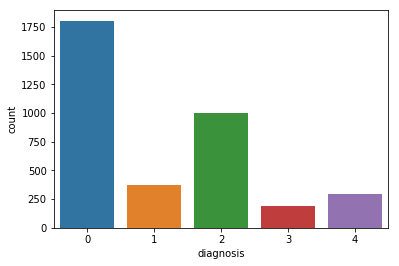

In [0]:
sns.countplot('diagnosis', data=train_df)

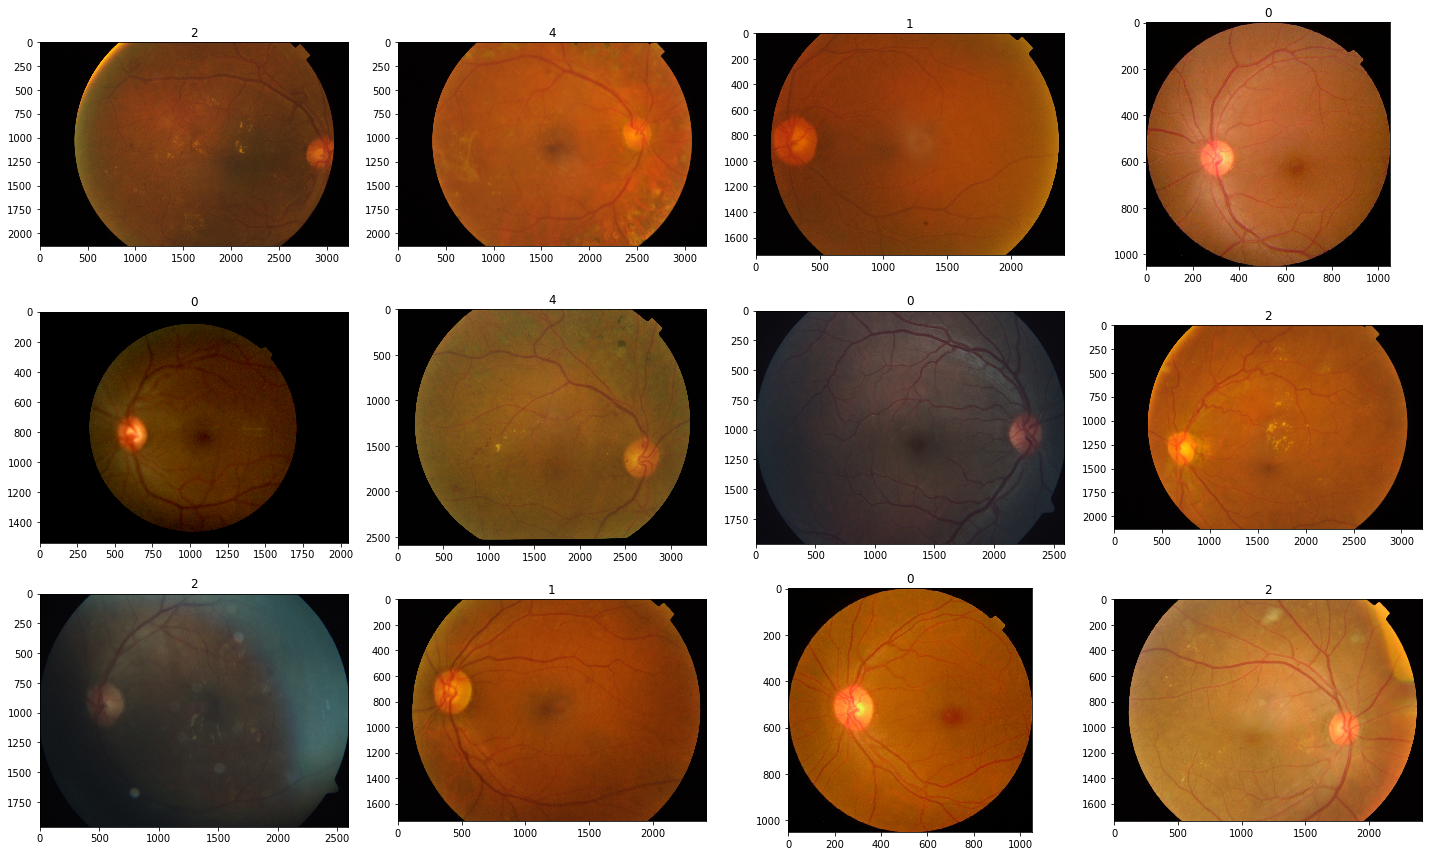

In [0]:
# display image from kernel : densenet-keras-starter

def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'/content/train_images/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

In [0]:
# display image from kernel : densenet-keras-starter

def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'/content/preprocess_train_v2/{image_path}.png')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

# project purpose

 1) apply quadratic weighted metircs during training
 
 2) compare image preprocessing 

In [0]:
train_df.shape

(3662, 3)

In [0]:
train_df.head()

id_code  diagnosis          img_path
0  000c1434d8d7          2  000c1434d8d7.png
1  001639a390f0          4  001639a390f0.png
2  0024cdab0c1e          1  0024cdab0c1e.png
3  002c21358ce6          0  002c21358ce6.png
4  005b95c28852          0  005b95c28852.png

In [0]:
train_df['diagnosis'] = train_df['diagnosis'].astype('str')

In [0]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 3 columns):
id_code      3662 non-null object
diagnosis    3662 non-null object
img_path     3662 non-null object
dtypes: object(3)
memory usage: 85.9+ KB


In [0]:
x= train_df[['id_code','img_path']]
y= train_df['diagnosis']

In [0]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1228, stratify = y)

In [0]:
X_train.head()

id_code          img_path
2225  9c514d2d5b3f  9c514d2d5b3f.png
2405  a8263d248523  a8263d248523.png
1252  57760be09c03  57760be09c03.png
2133  9688c6ef5dc5  9688c6ef5dc5.png
1852  82deb07a6618  82deb07a6618.png

In [0]:
y_train.head()

2225    0
2405    0
1252    2
2133    0
1852    2
Name: diagnosis, dtype: object

In [0]:
x_train_full = pd.concat([X_train, y_train], axis=1)
x_test_full = pd.concat([X_test, y_test], axis=1)

In [0]:
x_train_full.head()

id_code          img_path diagnosis
2225  9c514d2d5b3f  9c514d2d5b3f.png         0
2405  a8263d248523  a8263d248523.png         0
1252  57760be09c03  57760be09c03.png         2
2133  9688c6ef5dc5  9688c6ef5dc5.png         0
1852  82deb07a6618  82deb07a6618.png         2

In [0]:
train_gen = image.ImageDataGenerator(rescale = 1./255, 
                                     width_shift_range = 0.1,
                                     height_shift_range = 0.1,
                                     zoom_range=0.1,
                                     shear_range=0.1,
                                     horizontal_flip=True,
                                     vertical_flip=True)

test_gen = image.ImageDataGenerator(rescale = 1./255)

In [0]:
img_size = 255
img_dir = '/content/preprocess_train_v2'

In [0]:
train_data = train_gen.flow_from_dataframe(x_train_full, directory = img_dir, x_col = 'img_path', y_col='diagnosis', target_size=(img_size, img_size), batch_size=20)

test_data = test_gen.flow_from_dataframe(x_test_full, directory = img_dir, x_col = 'img_path', y_col='diagnosis', target_size=(img_size, img_size), batch_size=20, shuffle=False)

Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.


In [0]:
train_step = np.ceil(train_data.n // train_data.batch_size)
test_step = np.ceil(test_data.n // test_data.batch_size)

In [0]:
train_step

146.0

In [0]:
test_step

36.0

In [0]:
xception_model = Xception(include_top=False, weights=None, input_shape=(img_size,img_size,3))

In [0]:
model = models.Sequential()
model.add(xception_model)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(512, activation = 'relu', kernel_initializer=he_normal()))
model.add(layers.Dense(512, activation='relu', kernel_initializer=he_normal()))
model.add(layers.Dense(5, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 5)                 2565      
Total params: 22,175,789
Trainable params: 22,121,261
Non-trainable params: 54,528
_________________________________________________________________


In [0]:
counter = 0
for i in test_data:
#   print(i)
  
  print(i[0].shape)
  print(i[0])
  print(np.argmax(i[1], axis=1))
  counter += 1
  if counter == 1:
    break

(20, 255, 255, 3)
[[[[0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]
   ...
   [0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]]

  [[0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]
   ...
   [0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]]

  [[0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]
   ...
   [0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]]

  ...

  [[0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]
   ...
   [0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]
   [0.5019608  0.5019608  0.5019608 ]]

  [[0.5019608  0.5019608  0

In [0]:
def get_preds_and_labels(model, generator=test_data):
    """
    Get predictions and labels from the generator
    """
    preds = []
    labels = []
    for _ in range(int(np.ceil(generator.samples / BATCH_SIZE))):
        x, y = next(generator)
        preds.append(model.predict(x))
        labels.append(y)
    # Flatten list of numpy arrays
    return np.concatenate(preds).ravel(), np.concatenate(labels).ravel()

In [0]:
class Metrics(Callback):
    """
    A custom Keras callback for saving the best model
    according to the Quadratic Weighted Kappa (QWK) metric
    """
    def on_train_begin(self, logs={}):
        """
        Initialize list of QWK scores on validation data
        """
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        """
        Gets QWK score on the validation data
        """
        # Get predictions and convert to integers
        y_pred, labels = get_preds_and_labels(model, test_data)
        y_pred = np.rint(y_pred).astype(np.uint8).clip(0, 4)
        # We can use sklearns implementation of QWK straight out of the box
        # as long as we specify weights as 'quadratic'
        _val_kappa = cohen_kappa_score(labels, y_pred, weights='quadratic')
        self.val_kappas.append(_val_kappa)
        
        print(f"val_kappa: {round(_val_kappa, 4)}")
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save(SAVED_MODEL_NAME)
        return

In [0]:
call_mat = Metrics()

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [0]:
call_lr_reduce = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience=5, min_lr = 1e-9)

In [0]:
history = model.fit_generator(train_data, 
                    steps_per_epoch=train_step, 
                    epochs=100, 
                    validation_data=test_data, 
                    validation_steps=test_step, 
                    callbacks=[call_lr_reduce, call_mat])

Epoch 1/100
146/146 [==============================] - 164s 1s/step - loss: 0.5479 - acc: 0.7882 - val_loss: 2.5951 - val_acc: 0.4881


NameError: ignored